# Implementación de Modelos

In [10]:
# !apt install unzip
# !unzip -u '/content/sample_data/src.zip' -d '/content/sample_data/'

In [11]:
# import sys
# sys.path.append('/content/sample_data')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz


# Utilidades pre-procesamiento, pipelines y automatización de entrenamiento
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    KFold, 
    StratifiedKFold, 
    GridSearchCV
    )

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer

# Métricas de performance
from sklearn.metrics import (
    classification_report,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, auc,
    confusion_matrix
)

# Modelos
from src import TopKTabularMoE as tkm

from src.trainClassifiers import train_LogisticRegression # Custom LogisticRegression para evaluar en multiples tresholds.

# Diccionario con el grid de algoritmos y especificación de sus respectivos hiperparámetros
from src import benchmark_models


# Utilidades
import missingno as msno
import time
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any, Union
import warnings
warnings.filterwarnings('ignore')

## Carga y Preprocesamiento de datos

In [2]:
# Importación de los datos
url = 'https://raw.githubusercontent.com/tuliorozco/applied-statistics/refs/heads/main/data/diabetes_dataset.csv'
data = pd.read_csv(url)
data.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [4]:
# =================================== PREPROCESAMIENTO ===================================

# Eliminación de observaciones duplicadas
data = data.drop_duplicates()
print(f"Nuevo total de registros: {len(data)}")
print(data.shape)

# 1. Separar las features predictoras (X) de la variable objetivo/target (y).
TARGET_COL = 'diabetes'
X = data.drop('diabetes', axis=1)
y = data[TARGET_COL]

# 2. Clasificar los campos por tipo de variable para el pre-procesamiento adecuado
numerical_cols = ["age", "bmi", "hbA1c_level", "blood_glucose_level"] 

binary_cols = ['race:AfricanAmerican','race:Asian','race:Caucasian',
               'race:Hispanic','race:Other','hypertension','heart_disease'] 


categorical_cols = [col for col in data.columns if col not in numerical_cols + binary_cols]
categorical_cols.remove('diabetes') 


# 3. División Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)


# 4. Pre-procesamiento de los datos
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), categorical_cols),  
    ("num", StandardScaler(), numerical_cols),
    ("bin", "passthrough", binary_cols)  
])


Nuevo total de registros: 99986
(99986, 16)


## Metodología

### Especificación del Grid de Hiperparámetros por Tipo de Modelo

Teniendo en cuenta que los modelos a entrenar y analizar pueden ser ejecutados de forma automática mediante `GridSearchCV` (A excepción del algoritmo propuesto), se especificará un diccionario *models_config* estructurado de la siguiente forma:

* Key (clave): Identificación del tipo de algoritmo, ejemplo: KNN, LogisticRegresion, DecisionTree, etc.
* Value (valor): El conjunto de funciones (la implementación de cada algortimo en los paquetes `scikit-learn` o `xgboost`), los parámetros de inicialización del algoritmo (si los tiene) y sus respectivos hiperparámetros a evaluar en el entrenamiento. 

En la especificación se muestra de la siguiente manera:

```python
models_config = {
        'KNN': {
            'function': KNeighborsClassifier,
            'param_grid': {
            'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean']
            }   
        } ,
         'LogisticRegression': {
            'function': LogisticRegression,
            'init_params': {'max_iter': 1000, 'random_state': random_state}, 
            'param_grid': {
                'classifier__C': [0.01, 0.1, 1, 10, 100],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__solver': ['liblinear', 'saga']
            }
         },
    # Y así sucesivamente ...
    'MLP': {
        'function': MLPClassifier,
        'init_params': {
            'max_iter': 500,
            'random_state': 101
        },
        'param_grid': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'classifier__activation': ['relu', 'tanh'],
            'classifier__solver': ['adam', 'sgd'],
            'classifier__alpha': [0.0001, 0.001, 0.01]
        }
    }
}
```
Así mismo, se define una variable tipo `Dict` denominada *common_params* con las siguientes *key-values*:

* `X_train`: Variables predictoras del conjunto de entrenamiento.
* `X_test`: Variables predictoras del conjunto de test.
* `y_train`: Variable *target* del conjunto de entrenamiento.
* `y_test`: Variable *target* del conjunto de test.
* `cv_folds`: Número de pliegues para la validación cruzada (cross validation).
* `random_state`: Semilla de reproducibilidad.

### Entrenamiento: Algoritmos Clásicos

Definidos los algoritmos con sus respectivos hiperparámetros así como los parámetros comunes (conjuntos de entrenamiento y pruebas), se define un bucle *for* que recorrerá el diccionario y procesará cada algoritmo según lo especificado en *models_config*. Las métricas resultantes del entrenamiento se almacenarán en listas para el análisis comparativo posterior frente al modelo propuesto.

In [5]:
random_state = 101


# Parámetros comunes para el entrenamiento
common_params = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'cv_folds': 5,
    'random_state': random_state
}

In [5]:
results_df, best_config_df, roc_curves = benchmark_models.run_benchmark(
    common_params=common_params,
    preprocessor=preprocessor,
    balance=False   # Sin aplicar remuestreo balanceado mediante SMOTE ni SMOTE-Tomek
)


Entrenando modelo: KNN
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Entrenamiento completado. Tiempo entrenamiento KNN: 261.6229 segundos

Entrenando modelo: LogisticRegression
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Entrenamiento completado. Tiempo entrenamiento LogisticRegression: 74.8851 segundos

Entrenando modelo: DecisionTree
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Entrenamiento completado. Tiempo entrenamiento DecisionTree: 7.5441 segundos

Entrenando modelo: RandomForest
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Entrenamiento completado. Tiempo entrenamiento RandomForest: 212.1288 segundos

Entrenando modelo: XGBoost
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Entrenamiento completado. Tiempo entrenamiento XGBoost: 42.1395 segundos

Entrenando modelo: SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Entrenamiento completado. Tiempo entrenamiento SVM: 3225.7654 segu

### Entrenamiento Algoritmos Clásicos: Caso Regresión Logística

En el siguiente bloque se realiza el entrenamiento del modelo de regresión logística evaluando *tresholds* entre 0.30 y 0.50 (valor por defecto) y de este modo determinar el umbral con mejores métricas en la clasificación.

In [7]:
# Entreaniemto de modelo con algoritmo de Regresión Logística y evaluación con thresholds entre 0.30 y 0.50

# Definición de umbrales para la evaluación.
thresholds = [round(0.30 + i *0.02, 2) for i in range(10)]

results_lr_df, best_configs_lr = train_LogisticRegression(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    preprocessor=preprocessor,
    thresholds=thresholds,
    param_grid={
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    cv_folds=5,
    max_iter=1000,
    random_state=101
)

#### Entrenamiento `MoE Conformal Transformer`

---

Construcción del modelo:

Se inicia con la definición del diccionario *cat_vocab_sizes* que contendrá la relación de las variables categóricas (no binarias) del dataset y valores únicos por cada variable, información necesaria para la especificación de los embeddings requeridos por el modelo.

In [6]:
print("\nTamaños:")
print(f"Train:{X_train.shape}")
# print(f"Calibración:{X_cal.shape}")
print(f"Test:{X_test.shape}")

# Definir vocabularios para categóricas
cat_vocab_sizes = {col: data[col].nunique() for col in categorical_cols}
print(f"\nVocabulario variables categóricas = {cat_vocab_sizes}")


Tamaños:
Train:(69990, 15)
Test:(29996, 15)

Vocabulario variables categóricas = {'year': 7, 'gender': 3, 'location': 55, 'smoking_history': 6}


---

Preprocesamiento de los datos para el entrenamiento:

In [7]:
# --------------------- PREPROCESAMIENTO PARA TopKTabularMoE -------------------------------


from sklearn.preprocessing import OrdinalEncoder

# por si en el futuro aparecen categorías no vistas en el entrenamiento.
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# 2. Ajustar el codificador SOLO con los datos de entrenamiento (X_train)
#    y transformar X_train.
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])

#  Transformar X_test usando el encoder YA AJUSTADO. Es crucial no volver a hacer 'fit'.
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols]) # <-- Paso crucial para X_test


# Crear el DataFrame de entrenamiento completo
train_df = X_train.copy()
train_df[TARGET_COL] = y_train

# DataFrame para la función evaluate
test_df = X_test.copy()
test_df[TARGET_COL] = y_test # <-- Re-unimos X_test con y_test

print("Preprocesamiento terminado.")

Preprocesamiento terminado.


---

Especificación del modelo SparseTabularMoE:

En la siguiente sección se definen los parámetros e hiperparámetros para el entrenamiento del modelo.

In [ ]:
from src import spartan
import tensorflow as tf

# --- 2. Configuración de Estrategia Distribuida ---
strategy = tf.distribute.MirroredStrategy()
print(f'Estrategia distribuida activada. Dispositivos: {strategy.num_replicas_in_sync}')

d_model = 128

# Parámetros para construir la arquitectura del modelo
model_params = {
    'cont_cols': numerical_cols,
    'bin_cols': binary_cols,
    'cat_cols': categorical_cols,
    'cat_vocab_sizes': cat_vocab_sizes,
    'd_model': d_model,
    'num_heads': 4,
    'd_ff': 4 * d_model,
    'num_experts': 4,
    'num_layers': 2,
    'dropout': 0.1,
    'k': 2
}

# Parámetros para el proceso de entrenamiento
training_params = {
    'lr': 3e-4,
    'epochs': 30, # Puedes reducir las épocas para una CV más rápida
    'batch_size': 256 * strategy.num_replicas_in_sync,
    'target_col': TARGET_COL,
    'col_groups': { # Agrupamos las listas de columnas
        'cont_cols': numerical_cols,
        'bin_cols': binary_cols,
        'cat_cols': categorical_cols,
        'target_col': TARGET_COL
    }
}

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Estrategia distribuida activada. Dispositivos: 1


------

Entrenamiento del modelo:

El siguiente bloque de código permite ejecutar la validación cruzada especificando el número de folds requeridos. En este caso, usan 5 pliegues y el modelo se evalúa con umbrales contenidos en el intervalo [0.30, 0.50], con incremento en 0.05, dado el fuerte desbalanceo entre las clases de la variable objetivo (negativa con 91.5% vs 8.5% en la clase positiva).

In [ ]:
from src import spartan
from src.spartan import cross_validation as cv
# --- 4. Ejecutar la Validación Cruzada ---
# Una sola llamada a la función orquesta todo el proceso.
best_model, roc_dict, cv_results = cv.run_cross_validation(
    df_full_train=train_df, # Usando el DataFrame de entrenamiento completo
    target_col=TARGET_COL,
    strategy=strategy,
    model_build_params=model_params,
    training_params=training_params,
    n_splits=5, # Número de folds
    apply_smote=False, # No se aplica muestreo balanceado
    thresholds=[0.3, 0.35, 0.4, 0.45, 0.5]
)

print("\nCross-validation procesada.")

Iniciando validación cruzada con 5 folds...

### Resumen de la Validación Cruzada

| Criterio  | Mean        | Std Dev    |
|:----------|------------:|-----------:|
| Precision | 0.98012     | 0.037314   |
| Recall    | 0.50228     | 0.067733   |
| F1-Score  | 0.66024     | 0.051215   |
| Accuracy  | 0.95660     | 0.004213   |
| ROC-AUC   | 0.96780     | 0.002533   |
| TN        | 12792.44000 | 31.599156  |
| TP        | 597.84000   | 80.646699  |
| FP        | 15.56000    | 31.599156  |
| FN        | 592.16000   | 80.646699  |

Cross-validation procesada.

Con el modelo `SparseTabMoE` entrenado se procede con la evaluación de los resultados.

# Evaluación de Métricas de Performance

A continuación, se presentan en formato tabla las métricas de cada algoritmo con su mejor combinación de parámetros e hiperparámetros, así como la matriz de confusión de cada uno.

In [31]:
print("\n" + "="*100)
print(" "*35 + "TABLA COMPARATIVA DE RESULTADOS")
print("="*100)
results_df.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})


                                   TABLA COMPARATIVA DE RESULTADOS


Model,Precision,Recall,F1-Score,Accuracy,ROC-AUC,Best Params,TN,TP,FP,FN
KNN,0.987,0.522,0.683,0.959,0.929,"{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}",27428,1331,18,1219
LogisticRegression,0.875,0.628,0.732,0.961,0.960,"{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}",27218,1602,228,948
DecisionTree,0.972,0.676,0.798,0.971,0.974,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}",27397,1724,49,826
RandomForest,0.997,0.667,0.799,0.972,0.964,"{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}",27441,1701,5,849
XGBoost,0.985,0.677,0.803,0.972,0.978,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}",27420,1727,26,823
SVM,0.922,0.597,0.725,0.961,0.959,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",27318,1522,128,1028
MLP,0.939,0.682,0.790,0.969,0.972,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}",27333,1738,113,812


La tabla 1 muestra el resumen con el mejor modelo, a partir de la combinación de parámetros, de cada uno de los algoritmos clásicos analizados y destacando especialmente `XGBoost` y `RandomForest`, los cuales exhiben un rendimiento empírico excepcional en este conjunto de datos, con una exactitud superior al 97%. Ahora bien, dado el fuerte desbalanceo la exactitud no puede considerarse como la principal métrica para la selección del mejor modelo (ej., para `XGBoost`, TN=27420 vs. TP=1727). En contraste, el F1-score (0.803 para `XGBoost`) da una mejor imagen y es especialmente útil cuando la distribución de clases es desigual, ya que una alta exactitud (Accuracy) puede ocultar un pobre desempeño en la clase minoritaria.

Así mismo, se presenta un resumen con el algoritmo que obtuvo mejores resultados por cada métrica evaluada.

In [32]:
# Agrupar por métrica y seleccionar el índice del máximo en la columna 'Valor'
idx = best_config_df.groupby("Métrica")["Valor"].idxmax()

# Filtrar el DataFrame con esos índices
best_overall_df = best_config_df.loc[idx].reset_index(drop=True)

print("\n" + "="*100)
print(" "*35 + "TABLA COMPARATIVA DE RESULTADOS")
print("="*100)
best_overall_df.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})


                                   TABLA COMPARATIVA DE RESULTADOS


Modelo,Métrica,Valor,Parámetros
XGBoost,Accuracy,0.971696,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}"
XGBoost,F1-Score,0.802696,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}"
RandomForest,Precision,0.997069,"{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}"
XGBoost,ROC-AUC,0.978170,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}"
MLP,Recall,0.681569,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}"


La tabla 2 reafirma los resultados vistos inicialmente que señalan a `XGBoost` como el modelo con el mejor rendimiento general y equilibrado. Domina en las métricas que evalúan el desempeño global (*Accuracy* y *ROC-AUC*) y también en la que mide el balance entre precisión y sensibilidad para la clase minoritaria (*F1-Score*).

Comparativa de resultados en `LogisticRegression`:

Complementando el ejercicio, se presentan los resultados del modelo de clasificación por regresion logística `LogisticRegression`, para cada uno de los tresholds evaluados entre 0.30 a 0.48, con un incremento de 0.02 para compararlos frente a los resultados con el umbral 0.5 (valor por defecto).

In [35]:
results_lr_df.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})

Threshold,Precision,Recall,F1-Score,Accuracy,ROC-AUC,Best Params,TN,TP,FP,FN
0.300000,0.714,0.709,0.712,0.951,0.961,C: 0.1,26723,1808,723,742
0.320000,0.734,0.696,0.714,0.953,0.961,C: 0.1,26802,1774,644,776
0.340000,0.751,0.685,0.717,0.954,0.961,C: 0.1,26868,1747,578,803
0.360000,0.768,0.678,0.720,0.955,0.961,C: 0.1,26924,1728,522,822
0.380000,0.784,0.668,0.721,0.956,0.961,C: 0.1,26976,1704,470,846
0.400000,0.804,0.663,0.727,0.958,0.961,C: 0.1,27035,1690,411,860
0.420000,0.820,0.656,0.729,0.959,0.961,C: 0.1,27079,1673,367,877
0.440000,0.836,0.649,0.731,0.959,0.961,C: 0.1,27122,1654,324,896
0.460000,0.851,0.639,0.730,0.960,0.961,C: 0.1,27160,1630,286,920
0.480000,0.862,0.633,0.730,0.960,0.961,C: 0.1,27188,1614,258,936


La siguiente tabla muestra las configuraciones con mejores métricas para `LogisticRegression`:

In [36]:
best_configs_lr.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})

Métrica,Mejor Threshold,Valor,Parámetros
Precision,0.480000,0.862179,C: 0.1
Recall,0.300000,0.709020,C: 0.1
F1-Score,0.440000,0.730565,C: 0.1
Accuracy,0.480000,0.960195,C: 0.1
ROC-AUC,0.300000,0.960556,C: 0.1


In [33]:
import matplotlib.pyplot as plt

def plot_roc_curves(roc_curves):
    """
    Grafica curvas ROC a partir del diccionario roc_curves.
    
    roc_curves : dict
        { modelo: (fpr, tpr, roc_auc) }
    """
    plt.figure(figsize=(16, 10))

    for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.3f})")

    # Línea diagonal de azar
    plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("Curvas ROC comparativas", fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

Curvas *ROC-AUC* para los algoritmos clásicos:

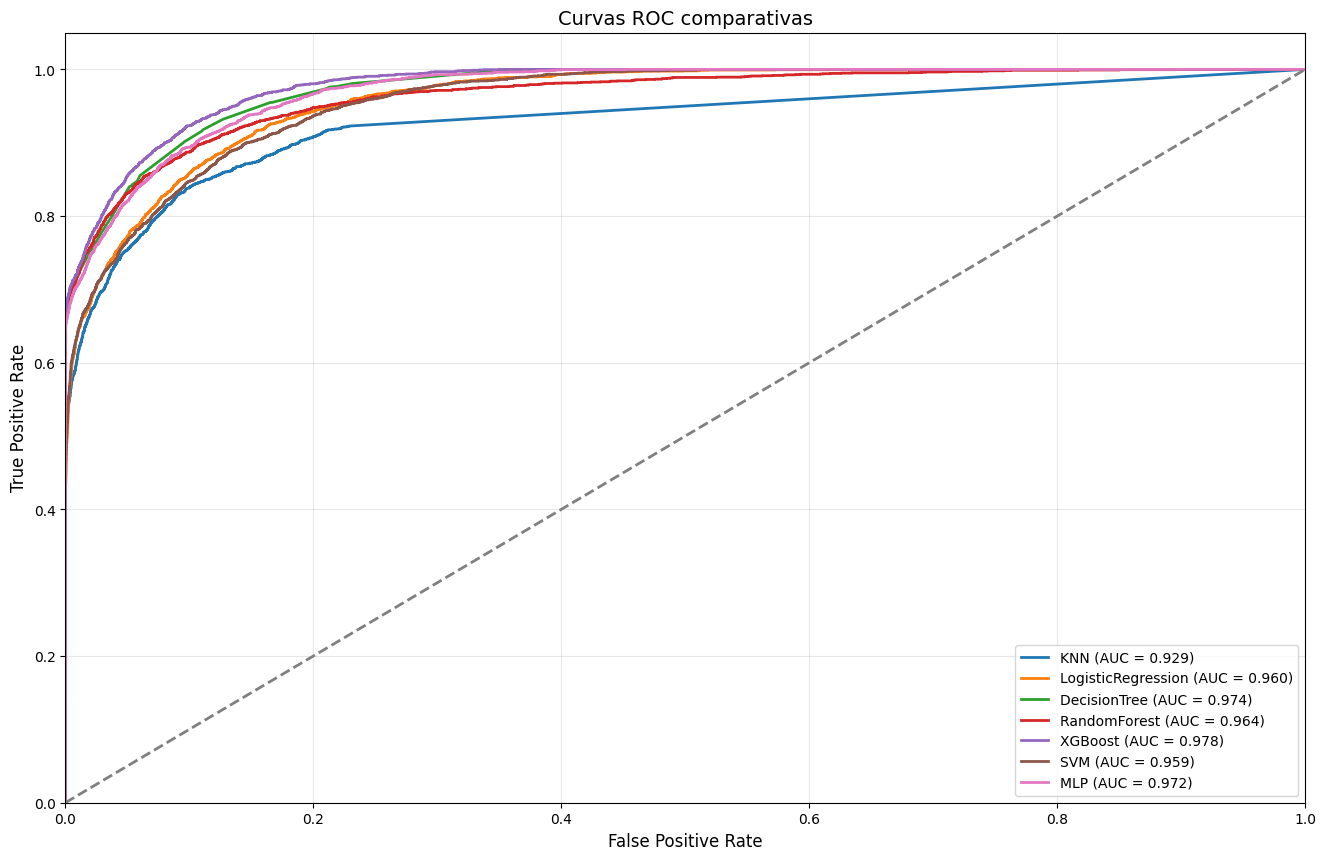

In [34]:
plot_roc_curves(roc_curves)

La figura 1 presenta una comparativa de las curvas ROC-AUC de cada uno de los algoritmos de clasificación analizados. El eje X representa la tasa de falsos positivos (FPR), mientras que el eje Y muestra la tasa de verdaderos positivos (TPR). Los resultados reflejan un buen comportamiento general de los modelos, ya que todos presentan valores de AUC superiores a 0.92, lo que indica un alto poder predictivo. Sin embargo, algunos destacan sobre los demás:

* XGBoost → Es el modelo con mejor desempeño (AUC = 0.978), logrando la mayor capacidad de discriminación entre clases.
* Decision Tree (AUC = 0.974) y MLP (red neuronal) (AUC = 0.972) → También ofrecen resultados sobresalientes, muy cercanos al rendimiento de XGBoost.
* Random Forest (AUC = 0.964) y SVM (AUC = 0.959) → Mantienen una buena precisión y estabilidad en las predicciones.
* Logistic Regression (AUC = 0.960) → A pesar de ser un modelo más simple, logra un rendimiento competitivo.
* KNN (AUC = 0.929) → Presenta el valor más bajo dentro del conjunto, pero aun así mantiene un desempeño aceptable.
En síntesis, el modelo XGBoost se posiciona como la mejor alternativa para la clasificación de pacientes con y sin diabetes, seguido muy de cerca por Decision Tree y MLP. Estos resultados evidencian que los modelos basados en aprendizaje no lineal y técnicas avanzadas de ensamble ofrecen mayor precisión y confiabilidad para este problema.  

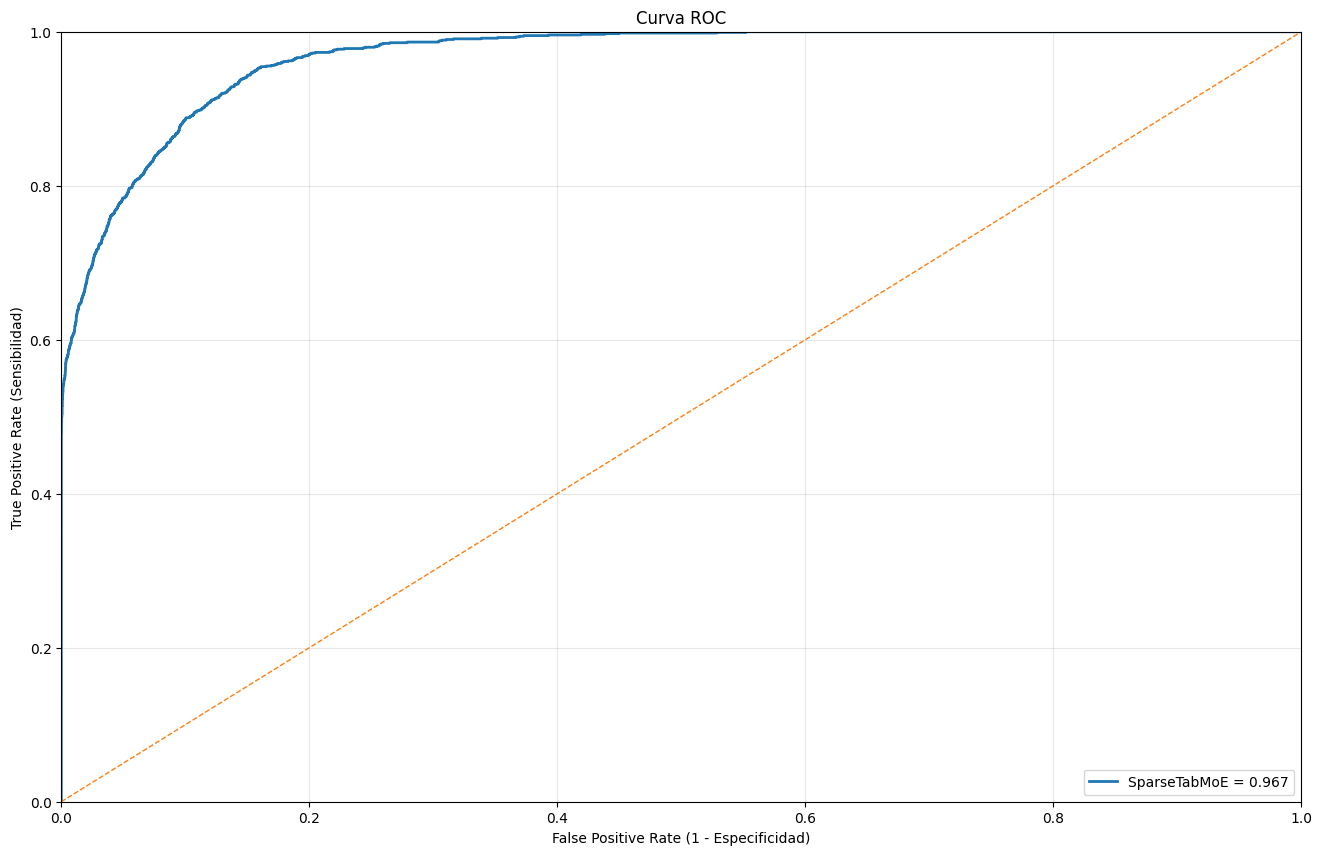

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.plot(roc_dict["fpr"], roc_dict["tpr"], lw=2, label=f"SparseTabMoE = {roc_dict['auc']:.3f}")
plt.plot([0, 1], [0, 1], "--", lw=1)
plt.xlim([0, 1]); plt.ylim([0, 1])
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curva ROC")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.show()

La figura 2 presenta gráfica de ROC-AUC para `SparseTabMoE`, que evidencia un AUC=0.967, entrando en la franja alta: esencialmente a la par de `RandomForest` y muy cerca de `MLP`/`DecisionTree`, aunque aún por debajo de `XGBoost` por un margen pequeño. Es decir, que el modelo ordena una instancia positiva por encima de una negativa 96.7% de las veces.  

In [15]:
print("\nAnálisis detallado por fold: SparseTabMoE")
cv_results


Análisis detallado por fold: SparseTabMoE


,Threshold,Precision,Recall,F1-Score,Accuracy,ROC-AUC,TN,TP,FP,FN,fold
0,0.30,0.917,0.575,0.707,0.959,0.968,12746,684,62,506,1
1,0.35,0.990,0.498,0.663,0.957,0.968,12802,593,6,597,1
2,0.40,1.000,0.454,0.624,0.954,0.968,12808,540,0,650,1
3,0.45,1.000,0.433,0.604,0.952,0.968,12808,515,0,675,1
4,0.50,1.000,0.418,0.590,0.951,0.968,12808,498,0,692,1
5,0.30,0.875,0.623,0.728,0.960,0.965,12702,741,106,449,2
6,0.35,0.963,0.546,0.697,0.960,0.965,12783,650,25,540,2
7,0.40,0.993,0.506,0.670,0.958,0.965,12804,602,4,588,2
8,0.45,0.998,0.478,0.647,0.956,0.965,12807,569,1,621,2
9,0.50,1.000,0.455,0.625,0.954,0.965,12808,541,0,649,2


La tabla 3 muestra el resumen de las métricas para el modelo *SparseTabMoE*, destacando en cada uno de los *folds* valores consistentemente altos y estables en el ROC-AUC, variando entre 0.965 y 0.968, lo que demuestra la capacidad del modelo para distinguir entre las clases, independientemente del umbral de clasificación. Con estos resultados en AUC tan cercanos a 1 se puede afirmar que el modelo posee un excelente poder discriminatorio. Si se toma un caso positivo y uno negativo al azar, el modelo tiene una probabilidad de entre el 96.5% y el 96.8% de asignar una puntuación de riesgo más alta al caso positivo. La estabilidad de esta métrica a lo largo de los pliegues es un fuerte indicio de que el modelo generaliza bien y no sufre de un sobreajuste significativo a una porción particular de los datos.

Por otra parte, el resumen revela además que al aumentar el umbral de decisión la precisión tiende a aumentar (llegando a 1 en varios casos), mientras que la sensibilidad disminuye sistemáticamente. Este comportamiento dice claramente que un umbral más alto hace que el modelo sea más "conservador" y solo clasificará una observación como positiva si la evidencia es abrumadora. Esto reduce drásticamente los Falsos Positivos (FP), llevando la precisión al máximo, pero a costa de ignorar casos positivos menos evidentes, lo que incrementa los Falsos Negativos (FN) y reduce la sensibilidad.

#### Aplicación de *Split Conformal Prediction* sobre los resultados de `SparseTabMoE`. 

Se divide el conjunto de entrenamiento en 2 subconjuntos para implementar la calibración del modelo:

* Train con el 80% de los datos del conjunto inicial de entrenamiento.
* Cal con el 20% de los datos del conjunto inicial de entrenamiento.

In [38]:
# --- 3. División y Procesamiento de Datos ---

X_train = common_params['X_train']
y_train = common_params['y_train']
# Dividir el conjunto train en entrenamiento (80%) y calibración (20%) para la calibración.
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# 2. Ajustar el codificador SOLO con los datos de entrenamiento (X_train)
#    y transformar X_train.
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])

#  Transformar X_cal y X_test usando el encoder YA AJUSTADO. Es crucial no volver a hacer 'fit'.
X_cal[categorical_cols] = encoder.transform(X_cal[categorical_cols])


# Crear el DataFrame de entrenamiento completo
train_df = X_train.copy()
train_df[TARGET_COL] = y_train

# Crear el DataFrame de calibración completo
cal_df = X_cal.copy()
cal_df[TARGET_COL] = y_cal

print("Tamaños:")
print(f"Train:{X_train.shape}")
print(f"Calibración:{X_cal.shape}")

Tamaños:
Train:(55992, 15)
Calibración:(13998, 15)


Luego se ejecuta el procedimiento para calcular los cuantiles de calibración por clase: $\widehat{q}_{0}$ y $\widehat{q}_{1}$. Mediante esta metodología se obtiene un cuantil específico para cada clase en vez de un único cuantil para todos los datos de calibración, lo que permite que el procedimiento se adapte a posibles desequilibrios en la dificultad de clasificación o en la calibración del modelo para cada clase.

In [39]:
from src.spartan import conformal
# --- PASO 4: CALIBRACIÓN CONFORMAL ---

# Usar el conjunto de calibración para encontrar un umbral de decisión con garantías estadísticas.
print("\nPaso 4: Realizando la calibración conformal...")
ALPHA = 0.1 # Nivel de error aceptable (queremos un 90% de confianza)

# 1. Recibe el diccionario completo en una sola variable
qhat_dict = conformal.calibrate_conformal_conditional(
    model=best_model,
    df_cal=cal_df,
    cont_cols=numerical_cols,
    bin_cols=binary_cols,
    cat_cols=categorical_cols,
    target_col=TARGET_COL,
    alpha=ALPHA
)

# 2. Extrae los valores numéricos del diccionario
qhat_0 = qhat_dict["qhat_0"]
qhat_1 = qhat_dict["qhat_1"]

# 3. Ahora puedes imprimir los valores numéricos correctamente
print(f"Nivel de error alpha: {ALPHA}")
print(f"Cuantil para la clase negativa (qhat_0): {qhat_0:.4f}")
print(f"Cuantil para la clase positiva (qhat_1): {qhat_1:.4f}")

# Opcional: Calcula y muestra los umbrales de decisión finales
# según la documentación de tu propia función
umbral_decision_negativo = qhat_0
umbral_decision_positivo = 1 - qhat_1

print("-" * 30)
print(f"Umbral de decisión para clase negativa (p <= qhat_0): {umbral_decision_negativo:.4f}")
print(f"Umbral de decisión para clase positiva (p >= 1 - qhat_1): {umbral_decision_positivo:.4f}")



Paso 4: Realizando la calibración conformal...
Nivel de error alpha: 0.1
Cuantil para la clase negativa (qhat_0): 0.1572
Cuantil para la clase positiva (qhat_1): 0.8399
------------------------------
Umbral de decisión para clase negativa (p <= qhat_0): 0.1572
Umbral de decisión para clase positiva (p >= 1 - qhat_1): 0.1601


#### Observación e Interpretación de los Resultados de la Calibración Conformal
* `Cuantil para la clase negativa` $\widehat{q}_{0}$: 0.1562: Este es el cuantil $(1 - \alpha)$ de los puntajes de no conformidad calculados para las observaciones de la clase negativa en el conjunto de calibración. Típicamente, para un modelo que produce probabilidades $p_{i}$, el puntaje de no conformidad para una observación $(x_{i}, y_{i})$ es $1 - \widehat{p}_{y_{i}}(x_{i})$. Por lo tanto, $\widehat{q}_{0}$ representa el umbral que captura al 90% de los puntajes de no conformidad "menos anómalos" para la clase negativa.

* `Cuantil para la clase positiva` $\widehat{q}_{1}$: 0.8480: Análogamente, este es el cuantil $(1 - \alpha)$ de los puntajes de no conformidad para las observaciones de la clase positiva en el conjunto de calibración.

#### Interpretación de los Umbrales de Decisión

Los cuantiles calculados en la sección anterior se utilizan para definir las reglas de inclusión de etiquetas en el conjunto de predicción para una nueva instancia $x_{new}$ con una probabilidad predicha $p = \widehat{p}(y=1|x_{new})$.

* Regla para la Clase Negativa (Etiqueta 0): 
    * El umbral es $p \leq 0.1572$
    * Interpretación: Para que la etiqueta "0" (clase negativa) sea incluida en el conjunto de predicción, la           probabilidad asignada por el modelo a la clase positiva (p) debe ser menor o igual a 0.1572. Esto es equivalente a decir que la probabilidad de la clase negativa, $1 - p$, debe ser mayor o igual a $1 - 0.1572 = 0.8428$. El modelo debe tener una "confianza" muy alta en la clase negativa para incluirla en el conjunto.

* Regla para la Clase Positiva (Etiqueta 1): 
    * El umbral es $p \geq 1 - \widehat{q}_{1} \rightarrow p \geq 1 − 0.8399 = 0.1601$
    * Interpretación: Para que la etiqueta "1" (clase positiva) sea incluida en el conjunto de predicción, la probabilidad asignada a esta misma clase $(p)$ debe ser mayor o igual a 0.1601. Este umbral es relativamente bajo, lo que sugiere que el modelo no necesita estar "excesivamente seguro" para considerar la clase positiva como una posibilidad válida bajo el nivel de confianza del 90%.

#### Evaluación Empírica en el Conjunto de Pruebas

Complementando el proceso de calibración, se procede con la evaluación del predictor conformal sobre el conjunto *Test*, que contiene el 29.99% del dataset inicial. Esta etapa es de gran importancia dado que es en esta instancia que se verifica si las garantías teóricas del método se sostienen en la práctica y además, los resultados pueden confirmar la validez y eficiencia del procedimiento. Al evaluar en el conjunto test se tiene que:

In [40]:
# --- PASO 5: EVALUACIÓN FINAL EN EL CONJUNTO DE PRUEBA ---
# Evaluar el rendimiento del modelo en datos nunca antes vistos.
print("\nPaso 5: Evaluando el modelo en el conjunto de prueba...")
# Primero, preparamos el df_test completo
df_test = X_test.copy()
df_test[TARGET_COL] = y_test


print("Tamaño dataset test:")
print(f"Train:{X_test.shape}")

# Evaluar con el umbral estándar de 0.5 como línea base
print("\n--- Evaluación con umbral estándar de 0.5 ---")
conformal_metrics = conformal.evaluate_conformal_sets(
    model=best_model,
    df_test=df_test,
    cont_cols=numerical_cols,
    bin_cols=binary_cols,
    cat_cols=categorical_cols,
    target_col=TARGET_COL,
    qhats=qhat_dict
)
print(conformal_metrics)


Paso 5: Evaluando el modelo en el conjunto de prueba...
Tamaño dataset test:
Train:(29996, 15)

--- Evaluación con umbral estándar de 0.5 ---
{'coverage': 0.8966528870516068, 'average_set_size': 0.9958327777036938}


**Interpretación de los resultados:**

* Validación de la Garantía de Cobertura Marginal

    * Resultado Clave: coverage: 0.89665 (89.66%).
    * Interpretación Teórica: El objetivo del procedimiento, fijado por el nivel de error $\alpha = 0.1$, es el de alcanzar una cobertura marginal de, como mínimo $1 - \alpha = 0.9$ (90%).
    * Análisis Empírico: La cobertura empírica obtenida en el conjunto de prueba es del 89.66%. Este valor está extraordinariamente cerca del nivel de confianza teórico del 90%. Esta es la validación más importante del modelo: el predictor conformal cumple su promesa. Las ligeras desviaciones entre la cobertura teórica y la empírica son esperables debido a los efectos de muestra finita, pero la proximidad del valor obtenido al valor nominal confirma que el método está correctamente calibrado y es robusto.

    En el contexto de este artículo, este resultado es la prueba fundamental de que el método proporciona un control de errores riguroso y predecible, a diferencia de los modelos de clasificación estándar cuya tasa de error en datos nuevos es desconocida.

* Análisis de la Eficiencia del Predictor

    * Resultado Clave: average_set_size: 0.99583.
    * Interpretación Teórica: La eficiencia de un predictor conformal se mide por el tamaño de los conjuntos de predicción que genera. Conjuntos más pequeños indican predicciones más informativas y, por lo tanto, una mayor eficiencia.
    * Análisis Empírico: Un tamaño de conjunto promedio de 0.99583 es un indicador de muy alta eficiencia. Esto revela dos comportamientos críticos del modelo:

        * Predicciones Mayoritariamente Unívocas: Dado que los conjuntos solo pueden tener tamaño 0 (vacío) o 1 (una clase) según nuestra calibración anterior, un promedio tan cercano a 1 significa que en la abrumadora mayoría de los casos, el modelo emitió una predicción única y definitiva $C(x) = {0} \text{ o } C(x) = {1}$.
        * Identificación de Instancias Ambiguas: El hecho de que el promedio sea ligeramente inferior a 1 confirma la existencia de conjuntos de predicción vacíos. Podemos estimar la proporción de estos casos: la proporción de conjuntos de tamaño 1 es aproximadamente 99.58%, lo que implica que la proporción de conjuntos vacíos (tamaño 0) es de aproximadamente 100%−99.58%=0.42%.

    Esto demuestra que el modelo es capaz de abstenerse de tomar una decisión en un subconjunto muy pequeño y específico (menos del 0.5%) de las instancias, que corresponden precisamente a aquellas que caen en la "zona de ambigüedad" (0.1572,0.1601) que identificamos previamente. El modelo está señalando de forma honesta cuándo no tiene la confianza del 90% para asignar una etiqueta.